# Lagranto plots

In [1]:
import warnings
warnings.filterwarnings('ignore')  # 'default'

In [2]:
from datetime import datetime, timedelta
import string
#
import h5py
from lagranto import Tra
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import metpy
import numpy as np
import pandas as pd
from pathlib import Path
#
import arke
#
import mypaths
from plot_utils import plotter, map_kw, LCC_KW, AXGR_KW, mstart_kw, mfin_kw
from common_defs import fcst_strs, hours, pl_cases, um_res, runs, UM_TIME_FMT

In [3]:
def calc_dist(lons, lats, axis=0, radius=6378137, extend=False):
    lon = np.rollaxis(np.radians(lons), axis=axis, start=0)
    lat = np.rollaxis(np.radians(lats), axis=axis, start=0)
    dlon = np.diff(lon, axis=0)
    dlat = np.diff(lat, axis=0)
    
    tmp = (np.sin(dlat/2)**2 + np.cos(lat[:-1, ...])
                             * np.cos(lat[1:, ...])
                             * np.sin(dlon/2)**2)
    dist = 2*np.arcsin(np.sqrt(tmp))
    dist = radius * dist / 1000.
    if extend:
        dist = np.concatenate([np.zeros(((1,) + dist.shape[1:])),
                               dist])
        
    return np.rollaxis(dist, 0, axis)

In [4]:
LCC_KW['ticks'] = [10, 5]

In [5]:
plt.style.use('paperfig.mplstyle')

In [6]:
imgname_mask = 'backtraj_{st_date:%Y%m%dT%H%MZ}_{en_date:%Y%m%dT%H%MZ}_{cases}.{fmt}'

In [7]:
vrbls = 'vort_mslp'

tracks = {}
for fcst in pl_cases.values():
    tracks[fcst] = {}
    for run in runs:
        input_dir = mypaths.trackdir / fcst / run
        tracks[fcst][run] = pd.read_csv(input_dir / f'pl_loc.{fcst}.{um_res}.{run}.{vrbls}.txt', parse_dates=[0])

In [9]:
varname = 'rel_vort'
fname = list(mypaths.trackdir.parent.glob('*.h5'))[0]  # lazily find the data file
with h5py.File(fname, 'r') as hf:
    max_inds = {}
    for fcst in pl_cases.values():
        max_inds[fcst] = {}
        for run in runs:
            vort_along_track = hf.get(fcst).get(run).get(varname).value
            max_inds[fcst][run] = f'{tracks[fcst][run].time[vort_along_track.argmax()]:{UM_TIME_FMT}}'

In [10]:
traj_all = {}
for fcst in fcst_strs:
    print(fcst)
    st_date = datetime.strptime(fcst, UM_TIME_FMT)
    traj_all[fcst] = {}
    for run in runs:
        max_vort_dt = datetime.strptime(max_inds[fcst]['ctrl'], UM_TIME_FMT)
        fname = mypaths.lagrantodir / f'{st_date:{UM_TIME_FMT}}' / f'{um_res}' / f'{run}' / f'bt_{max_vort_dt:%Y%m%d%H}_{run}.4'
        try:
            traj_all[fcst][run] = Tra(fname)
        except Exception as e:
            print(e)

20070404T1200Z
20080129T1200Z


In [11]:
north_box = (-20, 10, 82, 83)
east_box = (30, 40, 73, 79)
west_box = (-20, 0, 65, 74)
boxes = (north_box, east_box, west_box)

In [12]:
icolors = [dict(color=i) for i in ['C6', 'C8', 'C9']]

fill_between() takes from 3 to 7 positional arguments but 27 were given


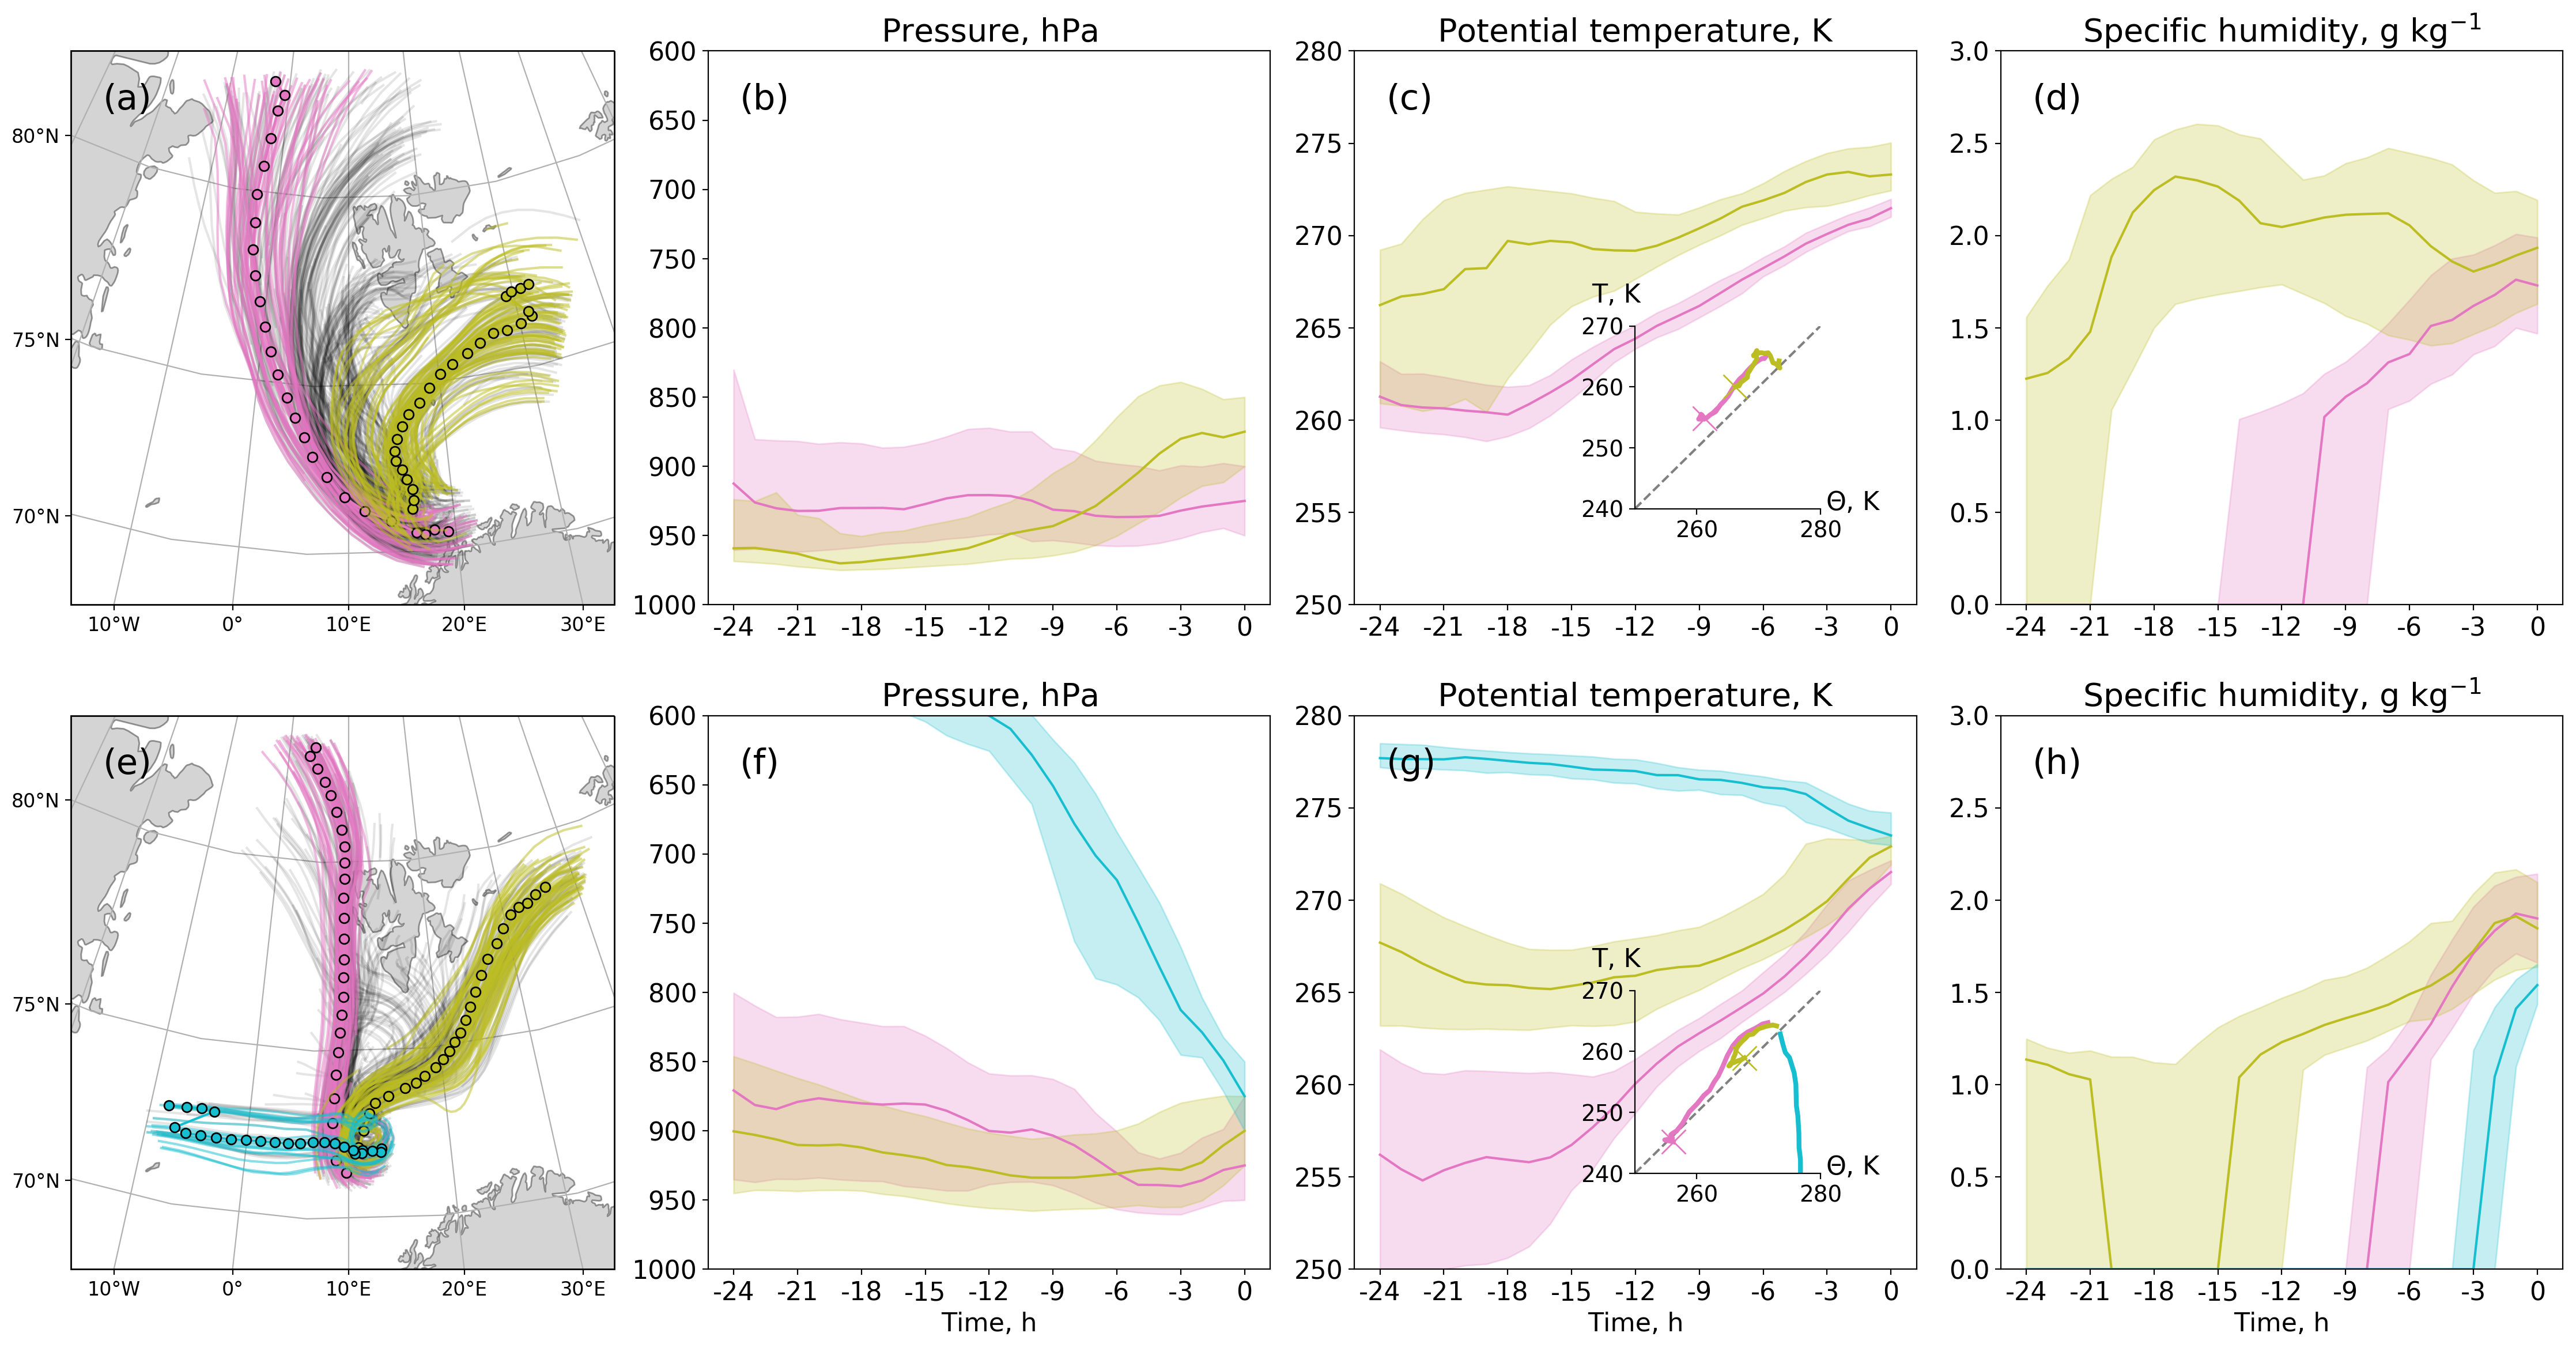

In [13]:
ncol = 4 # len(runs)
nrow = 2
axsize = 7

fig = plt.figure(figsize=(ncol*axsize, nrow*axsize))

all_ax = []

# axgr = arke.cart.lcc_map_grid(fig, (nrow, ncol), **LCC_KW, **AXGR_KW)

ax_labels = iter(string.ascii_lowercase)
box_kw = dict(color='none', hatch='///', edgecolor='k', zorder=100, linewidth=0.25)
sel = slice(None, None, 10)
for i, fcst_str in enumerate(fcst_strs):
    run = 'ctrl'
    
    t1 = 24 + 1
    lons = traj_all[fcst_str][run]['lon'].T[:t1, :]
    lats = traj_all[fcst_str][run]['lat'].T[:t1, :]
    pres = traj_all[fcst_str][run]['p'].T[:t1, :]
    temp = traj_all[fcst_str][run]['T'].T[:t1, :]
#     ghgt = traj_all[fcst_str][run]['GH'].T[:t1, :]
    spec = traj_all[fcst_str][run]['SP'].T[:t1, :]
    thta = metpy.calc.potential_temperature(pres * metpy.units.units('hPa'), temp*metpy.units.units('K')).magnitude

    mixr = spec / (1 - spec)
    vapor = metpy.calc.vapor_pressure(pres * metpy.units.units('hPa'), mixr)
    dew = metpy.calc.dewpoint(vapor)
    thte = metpy.calc.equivalent_potential_temperature(pres * metpy.units.units('hPa'), temp*metpy.units.units('K'), dew).magnitude    

    track_times = tracks[fcst_str][run]['time'].values.astype("<M8[ms]").astype(datetime)
    max_vort_dt = datetime.strptime(max_inds[fcst_str]['ctrl'], UM_TIME_FMT)  #using the same
    selected_row = tracks[fcst_str][run][track_times == max_vort_dt].values[0]
    _, lonc, latc = selected_row

    region = np.sqrt((lons[0, :] - lonc)**2 + 4*(lats[0, :] - latc)**2) < 2

    dist = calc_dist(lons, lats, axis=0, extend=True)

    mask_crit = ((dist>10000) | (pres<10) | (temp<220) | (temp>350))
    mlons = np.ma.masked_where(mask_crit, lons)
    mlats = np.ma.masked_where(mask_crit, lats)
    mpres = np.ma.masked_where(mask_crit, pres)
    mtemp = np.ma.masked_where(mask_crit, temp)
    mthta = np.ma.masked_where(mask_crit, thta)
    mthte = np.ma.masked_where(mask_crit, thte)
    mspec = np.ma.masked_where(mask_crit, spec)
#     mghgt = np.ma.masked_where(mask_crit, ghgt)
    
    condition =  (mpres[0, :] >= 850) & (mpres[0, :] < 975) & (mthta[0, :] >= 270)
    
    # Create axes
    ax = arke.cart.lcc_map(fig, nrow*100 + ncol*10 + 1 + ncol*i, **LCC_KW)
    all_ax.append(ax)
    
    vrbls = (mpres, mthta, mspec*1e3)#, mtemp, mthta, mspec)    
    ylimits = ((1000, 600), (250, 280), (0, 3))
    varnames = ('Pressure', 'Potential temperature', 'Specific humidity')
    units = ('$hPa$', '$K$', '$g$ $kg^{-1}$')

    ln_ax = []
    for ii, (vrbl, varname, un, ylims) in enumerate(zip(vrbls, varnames, units, ylimits)):
        ax1 = fig.add_subplot(nrow*100 + ncol*10 + 2 + ncol*i + ii)
        ax1.set_ylim(ylims)
        ax1.set_title(f'{varname}, {un}', fontsize=20)
        ax1.invert_xaxis()
        ax1.set_xticks(range(0, mlons.shape[0]+3, 3))
        ax1.set_xticklabels(range(0, -(mlons.shape[0]+3), -3))
        ax1.tick_params(labelsize=16)
        if i == 1:
            ax1.set_xlabel('Time, h', fontsize=16)
        ln_ax.append(ax1)
        all_ax.append(ax1)
    axins = inset_axes(ln_ax[1],
                       borderpad=3.75,
                       width="33%",  # width = 10% of parent_bbox width
                       height="33%",  # height : 50%
                       loc=4)
    axins.plot([250, 280], [240, 270], linestyle='--', color='grey')
    axins.set_xlim(250, 280)
    axins.set_ylim(240, 270)
    axins.tick_params(labelsize=14)
    axins.yaxis.set_label_coords(-0.1,1.1)
    axins.xaxis.set_label_coords(1.175, 0.1)
    axins.set_xlabel('$\Theta$, K', fontsize=16)
    axins.set_ylabel('T, K', rotation='horizontal', fontsize=16)
    axins.set_facecolor((0,0,0,0))


    for side in ['top', 'right']:
        axins.spines[side].set_visible(False)
        axins.tick_params(**{side: 'off'})

    ax.plot(mlons[:, condition][:, sel],
            mlats[:, condition][:, sel],
            color='k', alpha=0.1,
            **map_kw)
    for box, clr in zip(boxes, icolors):
        origin = ((lons > box[0]) &
                  (lons < box[1]) &
                  (lats > box[2]) &
                  (lats < box[3])).any(axis=0)
        try:
            ax.plot(mlons[:, condition & origin][:, sel],
                    mlats[:, condition & origin][:, sel],
                    **clr, alpha=0.5,
                    **map_kw)
            ax.plot(np.nanmedian(mlons[:, condition & origin][:, sel], axis=1),
                    np.nanmedian(mlats[:, condition & origin][:, sel], axis=1),
                    **clr, alpha=1, marker='o', mec='k',
                    **map_kw)
            
            # Line plots
            for ax1, vrbl in zip(ln_ax, vrbls):
                tt = np.arange(vrbl.shape[0])
                data = vrbl[:, condition & origin].filled(np.nan)
                _med = np.nanmedian(data, axis=1)
                iq = np.nanpercentile(data, [25, 75], axis=1)
                _ = ax1.fill_between(tt, *iq, alpha=0.25, **clr)
                _ = ax1.plot(tt, _med, alpha=1, **clr)
                
#             ax2 = fig.add_subplot(nrow*100 + ncol*10 + 2 + ncol*i + ii+1)
            thta_data = np.nanmedian(mthta[:, condition & origin].filled(np.nan), axis=1)
            temp_data = np.nanmedian(mtemp[:, condition & origin].filled(np.nan), axis=1)

#             iq = np.nanpercentile(data, [25, 75], axis=1)
#             _ = ax1.fill_between(tt, *iq, alpha=0.25, **clr)
            _ = axins.plot(thta_data, temp_data, linewidth=3, **clr)
            _ = axins.plot(thta_data[-1], temp_data[-1], marker='x', ms=15, **clr)
        except Exception as e:
            print(e)
            
fig.subplots_adjust(hspace=0.2, wspace=0.15)

for ax in all_ax:
    txt = f'({next(ax_labels)})'
    at = AnchoredText(txt, prop=dict(size=22), frameon=False, loc=2)
    ax.add_artist(at)

In [14]:
fig.savefig(mypaths.plotdir / f'traj_{run}_pres850-975_thta270_spec')